In [23]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import numpy as np
from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral
import GPy
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg
import random
from HetMOGP.likelihoods.gaussian import Gaussian
from HetMOGP.likelihoods.categorical import Categorical
from HetMOGP.het_likelihood import HetLikelihood
from HetMOGP import util
from HetMOGP.svmogp import SVMOGP

from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral



X1 = []
X2 = []
Y1 = []
Y2 = []
for i in range(10):
    for j in range(10):
        square = np.array([0,0,1,0,0,1,0,1,1,0,1,1,0])*1.0
        square[:12:2]+=i
        square[1:12:2]+=j
        X1.append(square)
        Y1.append(i)
        
        if j<5:
            point = np.full(13,np.NaN)
            point[0] = i
            point[1] = j
            point[-1] = 1
            X2.append(point)
            Y2.append(i)
X1 = np.array(X1)
Y1 = np.array(Y1)[:,None]
X2 = np.array(X2)
Y2 = np.array(Y2)[:,None]
numz = 20
Z = np.full([numz,X1.shape[1]],np.NaN)
Z[:,0:2] = np.random.rand(numz,2)
Z[:,0]=Z[:,0]*2
Z[:,-1]=1
X = [X1,X2]
Y = [Y1,Y2]
#kern = GPy.kern.RBF(2, lengthscale=10.0, variance = 1.0, ARD=False)
#oldshapek = ShapeIntegral(X1.shape[1],input_space_dim=2,Nperunit=5,kernel=kern)

In [24]:
X1.shape

(100, 13)

In [25]:
Y1.shape

(100, 1)

In [26]:
X2.shape

(50, 13)

In [27]:
Y2.shape

(50, 1)

In [28]:
Z.shape

(20, 13)

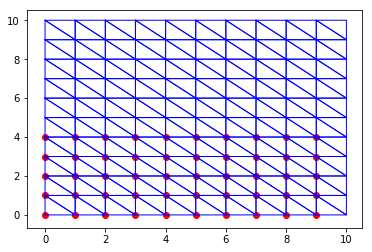

In [29]:
def plotsimplexes(X,Y,c,lw=1):
    for i,(x,y) in enumerate(zip(X,Y)):
        #plt.text(x[0],x[1],"%0.1f"%y)
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c,lw=lw)
        else:
            plt.scatter(x[0],x[1],color=c)
plotsimplexes(X1,Y1,'b')
plotsimplexes(X2,Y2,'r')

In [19]:
Y2.shape

(50, 1)

In [ ]:
likelihoods_list = [Gaussian(sigma=0.1), Gaussian(sigma=0.1)]
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)
Q = 1
W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)

kern_list=[ShapeIntegral(X[0].shape[1],2,kernel=GPy.kern.RBF(2,lengthscale=1.0),Nperunit=10)]
model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata)
model.kern.lengthscale.fix(1.0)
model.kern.variance.fix(10.0)

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /home/mike/Documents/Research/hetMOGPintegral/hetGPIntegralexperiments/shapeintegrals_fast_modified_for_hetGP.py:93: RuntimeWarning:divide by zero encountered in true_divide


In [ ]:
from HetMOGP.util import vem_algorithm as VEM

model=VEM(model,vem_iters=3,maxIter_perVEM=4,optZ=False,verbose=True,verbose_plot=False,non_chained=True)

In [ ]:
model.predictive_f_star(X2)

In [ ]:
testX = np.full([100,X1.shape[1]],np.NaN)
testX[:,0] = np.linspace(0,2,100)
testX[:,1] = 0.5
testX[:,-1] = 1
predY, varY = model.predictive_f_star(testX)

In [7]:
testX[:,0]

array([0.        , 0.02020202, 0.04040404, 0.06060606, 0.08080808,
       0.1010101 , 0.12121212, 0.14141414, 0.16161616, 0.18181818,
       0.2020202 , 0.22222222, 0.24242424, 0.26262626, 0.28282828,
       0.3030303 , 0.32323232, 0.34343434, 0.36363636, 0.38383838,
       0.4040404 , 0.42424242, 0.44444444, 0.46464646, 0.48484848,
       0.50505051, 0.52525253, 0.54545455, 0.56565657, 0.58585859,
       0.60606061, 0.62626263, 0.64646465, 0.66666667, 0.68686869,
       0.70707071, 0.72727273, 0.74747475, 0.76767677, 0.78787879,
       0.80808081, 0.82828283, 0.84848485, 0.86868687, 0.88888889,
       0.90909091, 0.92929293, 0.94949495, 0.96969697, 0.98989899,
       1.01010101, 1.03030303, 1.05050505, 1.07070707, 1.09090909,
       1.11111111, 1.13131313, 1.15151515, 1.17171717, 1.19191919,
       1.21212121, 1.23232323, 1.25252525, 1.27272727, 1.29292929,
       1.31313131, 1.33333333, 1.35353535, 1.37373737, 1.39393939,
       1.41414141, 1.43434343, 1.45454545, 1.47474747, 1.49494

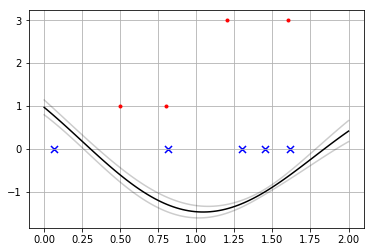

In [8]:
plt.plot(testX[:,0],predY,'-k',alpha=1)
plt.plot(testX[:,0],predY+np.sqrt(varY),'-k',alpha=0.2)
plt.plot(testX[:,0],predY-np.sqrt(varY),'-k',alpha=0.2)
#plt.ylim([-5,5])
plt.grid()
plt.scatter(Z[:,0],np.zeros(len(Z)),50,marker='x',color='b')
plt.plot(X2[:,0],Y2[:,0],'r.')

In [9]:
model.kern_list[0]

shapeintegral.,value,constraints,priors
variance,10.030925915191974,+ve,
lengthscale,1.0355022443691348,+ve,


In [11]:
model.B_q0.B

array([[ 0.05443088, -0.09227494],
       [-0.09227494,  0.15643076]])